# sanity check to remove all corrupt images (image generator is depricated)

In [20]:
from PIL import Image
import os

FORMAT_TO_EXT = {
    "JPEG": ".jpg",
    "PNG": ".png",
    "BMP": ".bmp",
    "GIF": ".gif",
    "TIFF": ".tiff",
    "WEBP": ".webp"
}

def fix_image_extensions(root_dir):
    fixed = 0
    checked = 0

    for root, _, files in os.walk(root_dir):
        for fname in files:
            path = os.path.join(root, fname)
            checked += 1

            try:
                with Image.open(path) as img:
                    fmt = img.format

                correct_ext = FORMAT_TO_EXT.get(fmt)
                if not correct_ext:
                    continue

                base, ext = os.path.splitext(fname)
                if ext.lower() != correct_ext:
                    new_path = os.path.join(root, base + correct_ext)
                    if not os.path.exists(new_path):
                        os.rename(path, new_path)
                        fixed += 1

            except Exception:
                pass

    print("\n===== EXTENSION FIX SUMMARY =====")
    print(f"Files checked : {checked}")
    print(f"Files renamed : {fixed}")
    print("================================")


In [21]:
fix_image_extensions("/home/vector/master_dataset")


/home/vector/anaconda3/envs/gpu/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))



===== EXTENSION FIX SUMMARY =====
Files checked : 41894
Files renamed : 0


In [22]:
from PIL import Image
import os

ROOT_DIR = "/home/vector/master_dataset"

def fix_png_named_as_jpg(root_dir):
    fixed = 0
    checked = 0

    for root, _, files in os.walk(root_dir):
        for fname in files:
            path = os.path.join(root, fname)
            checked += 1

            ext = os.path.splitext(fname)[1].lower()
            if ext not in [".jpg", ".jpeg", ".png"]:
                continue

            try:
                with Image.open(path) as img:
                    fmt = img.format  # REAL format from header

                # PNG pretending to be JPG
                if fmt == "PNG" and ext in [".jpg", ".jpeg"]:
                    new_path = os.path.splitext(path)[0] + ".png"
                    if not os.path.exists(new_path):
                        os.rename(path, new_path)
                        print("FIXED:", path, "->", new_path)
                        fixed += 1

            except Exception:
                pass

    print("\n===== PNG MISLABEL FIX SUMMARY =====")
    print(f"Files checked : {checked}")
    print(f"PNG→JPG fixed : {fixed}")
    print("===================================")

fix_png_named_as_jpg(ROOT_DIR)


===== PNG MISLABEL FIX SUMMARY =====
Files checked : 41894
PNG→JPG fixed : 0


In [23]:
import os
import shutil
from tensorflow.keras.utils import load_img

SRC_DIR = "/home/vector/master_dataset"
DST_DIR = "/home/vector/corrupt_files"

os.makedirs(DST_DIR, exist_ok=True)

def move_truly_corrupt_images(src_dir, dst_dir, img_size=(224, 224)):
    moved = 0
    checked = 0

    for root, _, files in os.walk(src_dir):
        for fname in files:
            path = os.path.join(root, fname)
            checked += 1

            try:
                # This is EXACTLY what ImageDataGenerator uses internally
                _ = load_img(path, target_size=img_size)
            except Exception:
                rel = os.path.relpath(path, src_dir)
                dst = os.path.join(dst_dir, rel)
                os.makedirs(os.path.dirname(dst), exist_ok=True)
                shutil.move(path, dst)
                print("MOVED:", path)
                moved += 1

    print("\n===== SUMMARY =====")
    print(f"Total files checked : {checked}")
    print(f"Corrupt files moved : {moved}")
    print(f"Clean files retained: {checked - moved}")
    print("===================")


In [24]:
move_truly_corrupt_images(SRC_DIR, DST_DIR)


/home/vector/anaconda3/envs/gpu/lib/python3.11/site-packages/PIL/Image.py:1034: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


MOVED: /home/vector/master_dataset/e_waste/e_waste_643.jpg
MOVED: /home/vector/master_dataset/paper_cardboard/paper_cardboard_2028.jpg
MOVED: /home/vector/master_dataset/paper_cardboard/paper_cardboard_5025.jpg
MOVED: /home/vector/master_dataset/plastic/plastic_5000.png

===== SUMMARY =====
Total files checked : 41894
Corrupt files moved : 4
Clean files retained: 41890


In [25]:
from load_dataset import load_dataset
train_ds, val_ds, class_indices = load_dataset()

Found 33240 images belonging to 8 classes.
Found 8306 images belonging to 8 classes.


In [28]:
def sanity_check_generator(gen):
    total_batches = len(gen)
    total_images = 0

    for i in range(total_batches):
        try:
            x, y = gen[i] 
            total_images += x.shape[0]
        except Exception as e:
            print(f"❌ Error in batch {i}: {e}")
            return

    print("✅ Sanity check passed")
    print(f"Total batches : {total_batches}")
    print(f"Total images  : {total_images}")

sanity_check_generator(train_ds)

/home/vector/anaconda3/envs/gpu/lib/python3.11/site-packages/PIL/Image.py:1034: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/vector/anaconda3/envs/gpu/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


✅ Sanity check passed
Total batches : 1039
Total images  : 33240


In [ ]:
sanity_check_generator(val_ds)

✅ Sanity check passed
Total batches : 260
Total images  : 8306


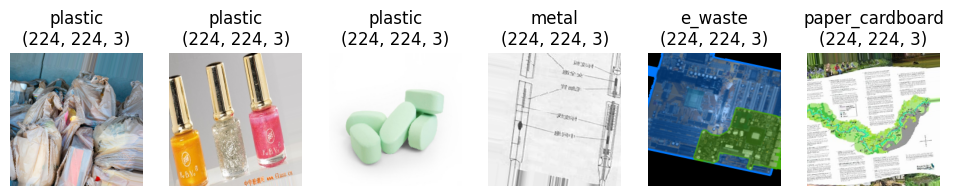

In [39]:
import matplotlib.pyplot as plt
import numpy as np

def show_samples(generator, class_indices, n=6):
    x, y = next(generator)

    idx_to_class = {v: k for k, v in class_indices.items()}

    plt.figure(figsize=(12, 4))
    for i in range(n):
        label_idx = np.argmax(y[i])
        label_name = idx_to_class[label_idx]

        plt.subplot(1, n, i + 1)
        plt.imshow(x[i])
        plt.title(f"{label_name}\n{x[i].shape}")
        plt.axis("off")
    plt.show()

show_samples(train_ds, class_indices, n=6)

In [ ]:
import os
import shutil

ROOT_DIR = "/home/vector/master_dataset"

# Magic byte signatures (authoritative)
MAGIC_TABLE = {
    b"\xFF\xD8\xFF": ".jpg",                     # JPEG
    b"\x89PNG\r\n\x1a\n": ".png",                # PNG
    b"RIFF": ".webp",                            # WEBP (needs further check)
    b"GIF87a": ".gif",                           # GIF
    b"GIF89a": ".gif",                           # GIF
    b"BM": ".bmp",                               # BMP
    b"II*\x00": ".tiff",                         # TIFF little endian
    b"MM\x00*": ".tiff",                         # TIFF big endian
}

def detect_extension(path):
    with open(path, "rb") as f:
        header = f.read(16)

    # JPEG
    if header.startswith(b"\xFF\xD8\xFF"):
        return ".jpg"

    # PNG
    if header.startswith(b"\x89PNG\r\n\x1a\n"):
        return ".png"

    # GIF
    if header.startswith(b"GIF87a") or header.startswith(b"GIF89a"):
        return ".gif"

    # BMP
    if header.startswith(b"BM"):
        return ".bmp"

    # TIFF
    if header.startswith(b"II*\x00") or header.startswith(b"MM\x00*"):
        return ".tiff"

    # WEBP (RIFF + WEBP signature)
    if header.startswith(b"RIFF") and b"WEBP" in header:
        return ".webp"

    return None  # not an image

def fix_extensions(root_dir):
    checked = 0
    fixed = 0
    skipped = 0

    for root, _, files in os.walk(root_dir):
        for fname in files:
            path = os.path.join(root, fname)
            checked += 1

            try:
                correct_ext = detect_extension(path)
                if correct_ext is None:
                    skipped += 1
                    continue

                base, old_ext = os.path.splitext(fname)
                old_ext = old_ext.lower()

                # force correct extension (even jpg -> jpeg, png -> png, etc)
                if old_ext != correct_ext:
                    new_path = os.path.join(root, base + correct_ext)

                    # avoid overwrite
                    if not os.path.exists(new_path):
                        os.rename(path, new_path)
                        print(f"FIXED: {path} -> {new_path}")
                        fixed += 1

            except Exception:
                skipped += 1

    print("\n===== EXTENSION FIX SUMMARY =====")
    print(f"Total files scanned : {checked}")
    print(f"Extensions fixed    : {fixed}")
    print(f"Files skipped       : {skipped}")
    print("================================")
fix_extensions(ROOT_DIR)

In [ ]:
# move unrecognized files
import os, shutil

SRC = "/home/vector/master_dataset"
DST = "/home/vector/corrupt_files"

os.makedirs(DST, exist_ok=True)

for root, _, files in os.walk(SRC):
    for f in files:
        path = os.path.join(root, f)
        if os.path.splitext(f)[1].lower() not in [".jpg", ".png", ".webp", ".gif", ".bmp", ".tiff"]:
            rel = os.path.relpath(path, SRC)
            dst = os.path.join(DST, rel)
            os.makedirs(os.path.dirname(dst), exist_ok=True)
            shutil.move(path, dst)

In [ ]:
import os
import shutil
from tensorflow.keras.utils import load_img

SRC_DIR = "/home/vector/master_dataset"
DST_DIR = "/home/vector/corrupt_files"

os.makedirs(DST_DIR, exist_ok=True)

def move_truly_corrupt_images(src_dir, dst_dir, img_size=(224,224)):
    moved = 0
    checked = 0

    for root, _, files in os.walk(src_dir):
        for fname in files:
            path = os.path.join(root, fname)
            checked += 1

            try:
                _ = load_img(path, target_size=img_size)
            except Exception:
                rel = os.path.relpath(path, src_dir)
                dst = os.path.join(dst_dir, rel)
                os.makedirs(os.path.dirname(dst), exist_ok=True)
                shutil.move(path, dst)
                print("MOVED:", path)
                moved += 1

    print("\n===== SUMMARY =====")
    print(f"Total files checked : {checked}")
    print(f"Corrupt files moved : {moved}")
    print(f"Clean files retained: {checked - moved}")
    print("===================")
move_truly_corrupt_images(SRC_DIR, DST_DIR)